
**Classification of medical symptoms**


*   Dataset Analysis 
*   Dataset pre-processing
*   Classification model
*   Model Evaluation







In [ ]:
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

from sklearn import preprocessing
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

## Initial Dataset Analysis

The dataset that this project is based on can be found in Kaggle via the following link: https://www.kaggle.com/paultimothymooney/medical-speech-transcription-and-intent


The dataset consists of audio utterances of patients (summing up to 8 hours of voice recordings) as well as transcriptions of each utterance (stored in *overview-of-recordings.csv*).
Each audio phrase / transcript is linked to a specific medical symptom. The main goal of this project is to train a model that classifies a transcript with the correct symptom. As the audio recordings have already been transcripted properly, no analysis of the .wav audio files fill be performed.



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
dataset_location = '/content/gdrive/MyDrive/MedicalSpeechDataset/overview-of-recordings.csv'

In [ ]:
# loading the data as pandas dataframe and showing the dataset size as well as a random row
recordings_overview = pd.read_csv(dataset_location)
recordings_overview.dropna(inplace = True)
recordings_overview = recordings_overview.reset_index()

print('Dataset size: ',len(recordings_overview.index))

Dataset size:  6661


In [ ]:
recordings_overview.sample(n = 1)

,index,audio_clipping,audio_clipping:confidence,background_noise_audible,background_noise_audible:confidence,overall_quality_of_the_audio,quiet_speaker,quiet_speaker:confidence,speaker_id,file_download,file_name,phrase,prompt,writer_id
432,432,no_clipping,1.0,light_noise,1.0,3.0,audible_speaker,1.0,43758322,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_43758322_24575606.wav,I'm having a hard time reading because the let...,Blurry vision,42082009


As no attention will be paid to the audio data, the irrelevant columns can be discarded. 

In [ ]:
transcripts_overview = recordings_overview[['phrase', 'prompt']]

pd.set_option('max_colwidth', 400)
transcripts_overview.sample(n = 5)

,phrase,prompt
4019,i cant sleep because of cough,Cough
5171,When I bend over I get a shooting pain down my back,Back pain
4360,My neck hurts me and i can't stand with this pain,Neck pain
5067,I cannot bear this squeezing sensation I have in my chest.,Heart hurts
5607,I feel pain in my knee when I climb the stairs.,Joint pain


In [ ]:
occurances_per_classes = transcripts_overview['prompt'].value_counts()
class_names = occurances_per_classes.index
occurances = occurances_per_classes.values
print('Overall number of classes: {}'.format(len(class_names)))

for i, class_name in enumerate(class_names):
    print('{}: {} samples'.format(class_name, occurances[i]))

Overall number of classes: 25
Acne: 328 samples
Shoulder pain: 320 samples
Joint pain: 318 samples
Infected wound: 306 samples
Knee pain: 305 samples
Cough: 293 samples
Feeling dizzy: 283 samples
Muscle pain: 282 samples
Heart hurts: 273 samples
Ear ache: 270 samples
Hair falling out: 264 samples
Head ache: 263 samples
Feeling cold: 263 samples
Skin issue: 262 samples
Stomach ache: 261 samples
Back pain: 259 samples
Neck pain: 251 samples
Internal pain: 248 samples
Blurry vision: 246 samples
Body feels weak: 241 samples
Hard to breath: 233 samples
Emotional pain: 231 samples
Injury from sports: 230 samples
Foot ache: 223 samples
Open wound: 208 samples


The plot below provides additional visual proof of the balanced dataset. There is no need to perform downsampling, upsampling or regularization.

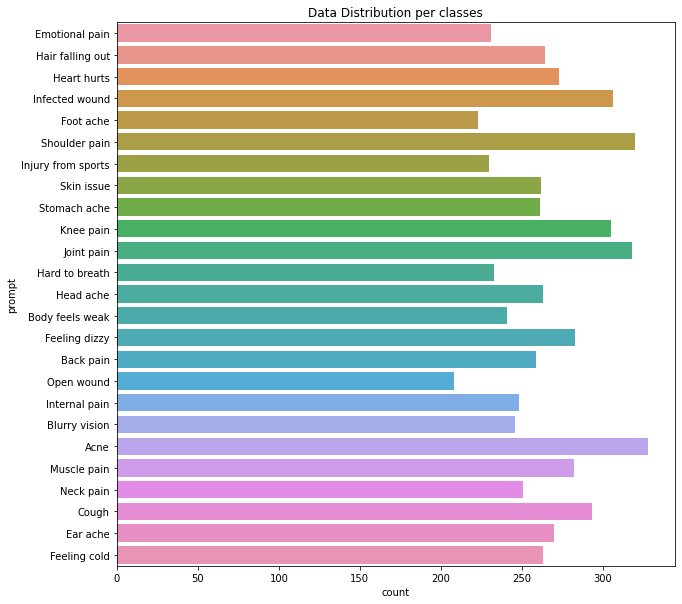

In [ ]:
plt.figure(figsize = (10,10))
plot = sns.countplot(y = 'prompt', data = transcripts_overview)
plot.set(title = 'Data Distribution per classes')
plt.show()

## Dataset Pre-processing

In [ ]:
phrases = transcripts_overview['phrase'].values
prompts = transcripts_overview['prompt'].values

### Phrases pre-processing with the help of 3 sub-functions :


1.   `clean_phrase` - removes punctuation, digits and lowers each word in a phrase
2.   `remove_stopwords_from_phrase` - removes stopwords (the, I, was, etc.)
3.  ` lemmatize_phrase` -  tokenizes and transforms a phrase






In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

def clean_phrase(text):
  #remove punctuation
  text = text.translate(str.maketrans('', '', string.punctuation))
  #remove digits
  sentence_without_digits = ''.join([word for word in text if not word.isdigit()])
  #lower all words
  sentence_lower_case = sentence_without_digits.lower()
  return sentence_lower_case

def lemmatize_phrase(text):
  wordlist = []
  lemmatizer = WordNetLemmatizer()
  sentences = nltk.sent_tokenize(text)

  initial_sentences = sentences[0:1]
  final_sentences = sentences[len(sentences) - 2 : len(sentences) - 1]

  for sentence in initial_sentences:
    words = nltk.word_tokenize(sentence)
    for word in words:
      wordlist.append(lemmatizer.lemmatize(word))
  
  for sentence in final_sentences:
    words = nltk.word_tokenize(sentence)
    for word in words:
      wordlist.append(lemmatizer.lemmatize(word))
  
  return ' '.join(wordlist)

def remove_stopwords_from_phrase(text):
  stop_words = set(stopwords.words("english"))
  words = nltk.word_tokenize(text)
  wordlist = [word for word in words if not word in stop_words]
  return ' '.join(wordlist)

def phrase_preprocessing(text):
  return lemmatize_phrase(remove_stopwords_from_phrase(clean_phrase(text)))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
print('Original phrase: ', phrases[521])
print('Phrase after pre-processing: ', phrase_preprocessing(phrases[521]))

Original phrase:  The worst headache was during a hangover in my twenties: I sincerely thought I was going to die from brain inflammation.
Phrase after pre-processing:  worst headache hangover twenty sincerely thought going die brain inflammation


In [ ]:
# applying the pre-processing to the ndarray 'phrases'
apply_function = np.vectorize(phrase_preprocessing)
preprcessed_phrases = apply_function(phrases)

### Label normalisation via LabelEncoder :

The classes are alphabetically sorted and enumerated. Each class is a string, whereas each label is a number from 0 to 24. The order has not changed.




In [ ]:
le = preprocessing.LabelEncoder()
labels = le.fit_transform(prompts)
print('Alphabetised prompt list: \n', le.classes_)

# Example: label 8 corresponds to class 'Feeling dizzy'
print('\nPhrase: {}\nPre-Processed Phrase: {}\nPrompt: {}\nCorresponding prompt label: {}'.format(phrases[150], preprcessed_phrases[150], prompts[150], labels[150]))

Alphabetised prompt list: 
 ['Acne' 'Back pain' 'Blurry vision' 'Body feels weak' 'Cough' 'Ear ache'
 'Emotional pain' 'Feeling cold' 'Feeling dizzy' 'Foot ache'
 'Hair falling out' 'Hard to breath' 'Head ache' 'Heart hurts'
 'Infected wound' 'Injury from sports' 'Internal pain' 'Joint pain'
 'Knee pain' 'Muscle pain' 'Neck pain' 'Open wound' 'Shoulder pain'
 'Skin issue' 'Stomach ache']

Phrase: I feel dizzy when I set in-front of my laptop for an hour or two, what possibly could be the reason?
Pre-Processed Phrase: feel dizzy set infront laptop hour two possibly could reason
Prompt: Feeling dizzy
Corresponding prompt label: 8


### Dataset being split (phrases and corresponding labels) into test and train sets with ratio 9 to 1.

In [ ]:
print('Dataset: ', transcripts_overview.shape)
print('Phrases: ', preprcessed_phrases.shape)
print('Labels: ', labels.shape)

Dataset:  (6661, 2)
Phrases:  (6661,)
Labels:  (6661,)


In [ ]:
train_dataset, test_dataset, train_labels, test_labels = train_test_split(preprcessed_phrases, labels, stratify = labels, random_state = 42, train_size=0.9)
print('Training set:', train_dataset.shape, train_labels.shape)
print('Test set:', test_dataset.shape, test_labels.shape)

Training set: (5994,) (5994,)
Test set: (667,) (667,)



> The usage of stratification would have lead to equal classes proportion in the training and the test dataset. The plot below provides visual proof.



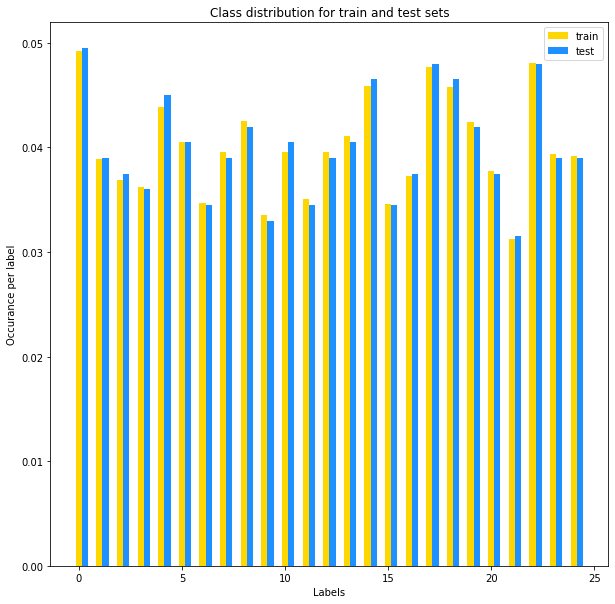

In [ ]:
plt.figure(figsize = (10,10))
width = 0.3
train_classes, train_counts = np.unique(train_labels, return_counts=True)
plt.bar(train_classes, train_counts/np.sum(train_counts), width, color = 'gold')

test_classes, test_counts = np.unique(test_labels, return_counts=True)
plt.bar(test_classes + width, test_counts/np.sum(test_counts), width, color = 'dodgerblue')
plt.legend(['train', 'test'])
plt.title('Class distribution for train and test sets')
plt.xlabel('Labels')
plt.ylabel('Occurance per label')
plt.show()

## Classification model

In [ ]:
# applying tf-idf to train data with the help of fit_transofrm(), 
# fit_transform() - used to scale the training data and learn the scaling parameters of that data. 
tfidf_vectorizer = TfidfVectorizer(max_df = 0.75)
tf_train_dataset = tfidf_vectorizer.fit_transform(train_dataset)
feature_names = tfidf_vectorizer.get_feature_names_out()
print(sorted(feature_names))
pd.DataFrame(tf_train_dataset.toarray(), columns = feature_names)

['abdomen', 'abdominal', 'able', 'abronchial', 'accident', 'accidentally', 'accompanied', 'ache', 'aching', 'acne', 'across', 'active', 'actually', 'acupuncture', 'adult', 'affected', 'afraid', 'ago', 'agreat', 'air', 'allergy', 'almost', 'along', 'alot', 'although', 'always', 'amount', 'analysis', 'anemia', 'ankle', 'annoyance', 'annoying', 'annoys', 'another', 'answer', 'antibiotic', 'anymore', 'anything', 'anytime', 'appendicitis', 'apply', 'arch', 'area', 'arm', 'around', 'arrived', 'asthma', 'ate', 'attack', 'awake', 'away', 'awful', 'bacause', 'back', 'bad', 'badly', 'bag', 'bald', 'ball', 'barely', 'basketball', 'bdeficiency', 'bear', 'beating', 'became', 'become', 'bed', 'beeing', 'beginning', 'believe', 'belly', 'bend', 'bent', 'better', 'bicep', 'biceps', 'big', 'bike', 'bit', 'blackhead', 'blanket', 'bleeding', 'bloating', 'blood', 'blur', 'blurred', 'blurry', 'body', 'bone', 'boneonbone', 'book', 'bother', 'bottom', 'bowel', 'brain', 'break', 'breaking', 'breakout', 'breaku

,abdomen,abdominal,able,abronchial,accident,accidentally,accompanied,ache,aching,acne,across,active,actually,acupuncture,adult,affected,afraid,ago,agreat,air,allergy,almost,along,alot,although,always,amount,analysis,anemia,ankle,annoyance,annoying,annoys,another,answer,antibiotic,anymore,anything,anytime,appendicitis,...,wearing,week,weight,weightlifting,well,went,whats,wheel,whenever,whitehead,whole,whooping,wich,wide,window,winter,wish,without,woke,woman,wont,work,working,world,worried,worse,worst,would,wouldnt,wound,wrap,write,wrong,yard,year,yellow,yesterday,young,zit,ït
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# transform() - used to scale the test data only, so as not to introduce bias
tf_test_dataset = tfidf_vectorizer.transform(test_dataset)

In [ ]:
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(tf_train_dataset, train_labels)

MultinomialNB()

## Model Evaluation

In [ ]:
train_prediction = naive_bayes_classifier.predict(tf_train_dataset)
train_accuracy = np.mean(train_prediction == train_labels) 
print('Train Accuracy: {:.2%}'.format(train_accuracy))

test_prediction = naive_bayes_classifier.predict(tf_test_dataset)
test_accuracy = np.mean(test_prediction == test_labels) 
print('Train Accuracy: {:.2%}'.format(test_accuracy))

conf_matrix = confusion_matrix(test_labels, test_prediction)

Train Accuracy: 98.77%
Train Accuracy: 97.75%


### Confusion matrix visualisation and Classification Report

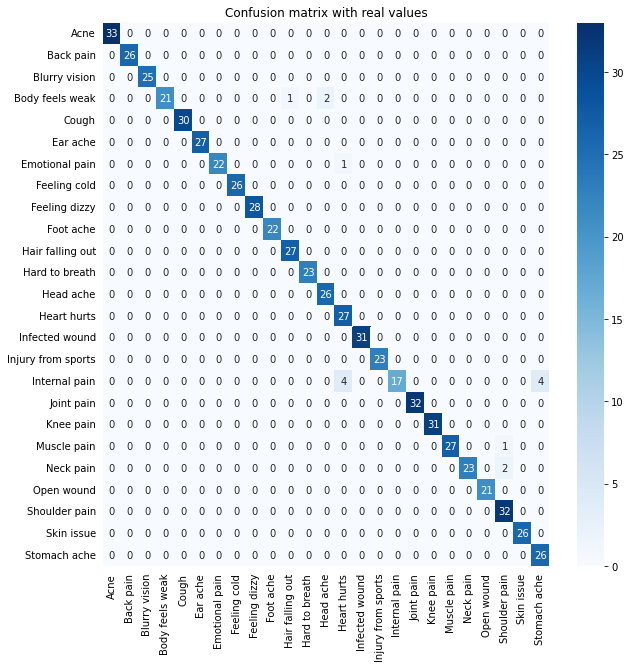

In [ ]:
plt.figure(figsize = (10,10))
plt.title('Confusion matrix with real values')
categories = le.classes_
plot = sns.heatmap(conf_matrix, xticklabels=categories, yticklabels=categories, annot=True, fmt='0.0f', cmap='Blues')
plot.set_yticklabels(plot.get_yticklabels(), rotation = 0, fontsize = 10)
plot.tick_params(left=False, bottom=False)

In [ ]:
print(classification_report(test_labels, test_prediction, target_names=le.classes_))

                    precision    recall  f1-score   support

              Acne       1.00      1.00      1.00        33
         Back pain       1.00      1.00      1.00        26
     Blurry vision       1.00      1.00      1.00        25
   Body feels weak       1.00      0.88      0.93        24
             Cough       1.00      1.00      1.00        30
          Ear ache       1.00      1.00      1.00        27
    Emotional pain       1.00      0.96      0.98        23
      Feeling cold       1.00      1.00      1.00        26
     Feeling dizzy       1.00      1.00      1.00        28
         Foot ache       1.00      1.00      1.00        22
  Hair falling out       0.96      1.00      0.98        27
    Hard to breath       1.00      1.00      1.00        23
         Head ache       0.93      1.00      0.96        26
       Heart hurts       0.84      1.00      0.92        27
    Infected wound       1.00      1.00      1.00        31
Injury from sports       1.00      1.00

Testing a newly introduced phrase

In [ ]:
new_phrase = ["My knees are aching"]
pre_processed_sent = phrase_preprocessing(new_phrase[0])
print(pre_processed_sent)
new_phrase = [pre_processed_sent]

knee aching


In [ ]:
test_input = tfidf_vectorizer.transform(new_phrase)
res = naive_bayes_classifier.predict(test_input)[0]
print('Phrase: {}\nClassified as: {}'.format(new_phrase[0], le.classes_[res]))

Phrase: knee aching
Classified as: Knee pain
